In [1]:
%matplotlib notebook
import os
import string
import numpy as np
import torch
from torch import nn
from torch.nn import functional as F
import torch.utils.data as td
import torchvision as tv
import pandas as pd
from PIL import Image
from matplotlib import pyplot as plt

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cuda


In [3]:
dataset_root_dir = '/home/stosifia/ML_Art_Proj/ml-art-final-shawheen-t-final/abstract_64x64'

In [4]:
class ArtDataset(td.Dataset):
    
    def __init__(self, root_dir, mode="ABSTRACT_groundTruth", image_size=(64, 64)):
        super(ArtDataset, self).__init__()
        self.image_size = image_size
        self.mode = mode
        self.dir = root_dir
        self.data = pd.read_csv(os.path.join(root_dir, "%s.csv" % mode))
        self.data[['Amusement','Anger','Awe','Content','Disgust','Excitement','Fear',
                   'Sad']] = self.data[['Amusement','Anger','Awe','Content','Disgust','Excitement','Fear','Sad']].apply(pd.to_numeric)
        self.data['class'] = self.data[['Amusement',
                                           'Anger','Awe','Content','Disgust','Excitement','Fear','Sad']].apply(lambda x: x.argmax(), axis=1)
        self.images_dir = os.path.join(root_dir, '/Images')
        map_dict = {'Amusement': 0,'Anger': 1,'Awe': 2,'Content': 3,'Disgust': 4,'Excitement': 5,'Fear': 6,
                   'Sad': 7}
        self.data['class'] = self.data['class'].map(map_dict)
        
    def __len__(self):
        return len(self.data)
    
    def __repr__(self):
        return "ArtDataset(mode={}, image_size={})". \
            format(self.mode, self.image_size)
    
    def __getitem__(self, idx):
        #img_path = os.path.join(self.images_dir, \
        #                        self.data.iloc[idx]['file_path'])
        file_path = self.data.iloc[idx]['file_path'].replace("'", "")
        img_path = self.dir + self.images_dir + '/' + file_path
        #bbox = self.data.iloc[idx][['x1', 'y1', 'x2', 'y2']]
        img = Image.open(img_path).convert('RGB')
        print(type(img))
        #img = img.crop([bbox[0], bbox[1], bbox[2], bbox[3]])
        transform = tv.transforms.Compose([
            tv.transforms.Resize(self.image_size),
            tv.transforms.ToTensor(),
            tv.transforms.Normalize((.5,.5,.5),(.5,.5,.5),inplace=False)
            ])
        x = transform(img)
        d = self.data.iloc[idx]['class']
        return x, d
    
    def number_of_classes(self):
        return self.data['class'].max() + 1

In [22]:
def myimshow(image, ax=plt):
    image = image.to('cpu').numpy()
    image = np.moveaxis(image, [0, 1, 2], [2, 0, 1])
    image = (image + 1) / 2
    image[image < 0] = 0
    image[image > 1] = 1 
    h = ax.imshow(image)
    ax.axis('off')
    return h

In [6]:
train_set = ArtDataset(dataset_root_dir)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: FutureWarning: 
The current behaviour of 'Series.argmax' is deprecated, use 'idxmax'
instead.
The behavior of 'argmax' will be corrected to return the positional
maximum in the future. For now, use 'series.values.argmax' or
'np.argmax(np.array(values))' to get the position of the maximum
row.
  if sys.path[0] == '':


In [7]:
import nntools as nt

In [8]:
class NNClassifier(nt.NeuralNetwork):
    def __init__(self):
        super(NNClassifier, self).__init__()
        self.cross_entropy = nn.CrossEntropyLoss()
        
    def criterion(self, y, d):
        return self.cross_entropy(y, d)

In [9]:
vgg = tv.models.vgg16_bn(pretrained=True)

In [10]:
class VGG16Transfer(NNClassifier):
    def __init__(self, num_classes, fine_tuning=False):
        super(VGG16Transfer, self).__init__()
        vgg = tv.models.vgg16_bn(pretrained=True)
        for param in vgg.parameters():
            param.requires_grad = fine_tuning
        self.features = vgg.features;
        self.classifier = vgg.classifier
        self.avgpool = vgg.avgpool
       
       

        num_ftrs = vgg.classifier[6].in_features
        self.classifier[6] = nn.Linear(num_ftrs, num_classes)
        
        
    def forward(self, x):
        x = self.features(x)
        x = self.avgpool(x)
        f = torch.flatten(x, 1)
        y = self.classifier(f)
        return y

In [11]:
num_classes = train_set.number_of_classes()

In [12]:
class ClassificationStatsManager(nt.StatsManager):
    def __init__(self):
        super(ClassificationStatsManager, self).__init__()
        
    def init(self):
        super(ClassificationStatsManager, self).init()
        self.running_accuracy = 0
        
    def accumulate(self, loss, x, y, d):
        super(ClassificationStatsManager, self).accumulate(loss, x, y, d)
        _, l = torch.max(y, 1)
        self.l = l
        #self.running_accuracy += torch.mean((l == d).float())
        self.running_accuracy = torch.mean((l == d).float())
        
    def summarize(self):
        loss = super(ClassificationStatsManager, self).summarize()
        #accuracy = 100 * torch.mean((self.l == d).float())
        # COMPLETE
        accuracy = 100 * self.running_accuracy
        return {'loss': loss, 'accuracy': accuracy}

In [15]:
class GANAlbumCovers(td.Dataset):
    
    def __init__(self, root_dir, image_size=(64, 64)):
        super(GANAlbumCovers, self).__init__()
        self.image_size = image_size
        self.dir = root_dir
        self.dirs = os.listdir(root_dir)
        self.data = self.dirs
        for k in self.dirs:
            if k.split('.')[-1] != 'png':
                self.dirs.remove(k)
                
        
    def __len__(self):
        return len(self.data)
    
    def __repr__(self):
        return "GANAlbumCovers(image_size={})". \
            format(self.image_size)
    
    
    
    def __getitem__(self, idx):
        file_path = self.dirs[idx]
        img_path = self.dir + '/' + file_path
        img = Image.open(img_path).convert('RGB')
        transform = tv.transforms.Compose([
            tv.transforms.Resize(self.image_size),
            tv.transforms.ToTensor(),
            tv.transforms.Normalize((.5,.5,.5),(.5,.5,.5),inplace=False)
            ])
        x = transform(img)
        return x

In [16]:
pred_set = GANAlbumCovers('GANAlbumArt')

In [17]:
val_set = GANAlbumCovers('GANAlbumArt')
pred_set = GANAlbumCovers('GANAlbumArt')
lr = 1e-3
net = VGG16Transfer(num_classes)
net = net.to(device)
adam = torch.optim.Adam(net.parameters(), lr=lr)
stats_manager = ClassificationStatsManager()
exp1 = nt.Experiment(net, train_set, val_set, pred_set, adam, stats_manager,
               output_dir="abstractclass1", perform_validation_during_training=False)

In [18]:
def plot(exp, fig, axes):
    axes[0].clear()
    axes[1].clear()
    axes[0].set_title('Training Loss')
    axes[1].set_title('Training Accuracy')
    axes[0].plot([exp.history[k]['loss'] for k in range(exp.epoch)],
                 label='training loss')
    axes[1].plot([exp.history[k]['accuracy'] for k in range(exp.epoch)],
                 label='training accuracy')
    plt.tight_layout()
    fig.canvas.draw()

<IPython.core.display.Javascript object>


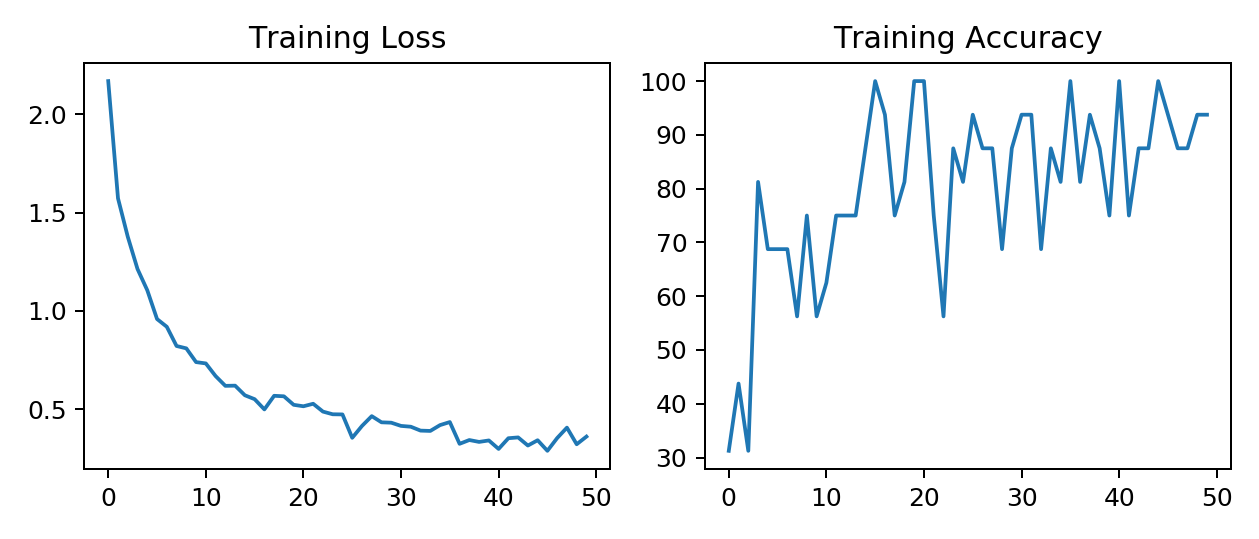

Start/Continue training from epoch 0
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
tensor([5, 2, 7, 5, 3, 7, 5, 2, 6, 2, 5, 5, 2, 1, 3, 3], device='cuda:0')
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
tensor([7, 2, 0, 7, 2, 7, 0, 7, 7, 7, 3, 7, 7, 7, 7, 7], 

<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
tensor([3, 0, 3, 0, 3, 0, 6, 0, 3, 6, 0, 3, 3, 3, 3, 3], device='cuda:0')
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
tensor([3, 3, 4, 7, 3, 0, 3, 3, 6, 3, 5, 0, 5, 2, 7, 3], device='cuda:0')
<class 'PIL.Image.Im

<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
tensor([6, 7, 6, 3, 2, 6, 3, 3, 3, 0, 2, 5, 0, 7, 6, 3], device='cuda:0')
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
tensor([6, 2, 5, 6, 0, 3, 6, 6, 3, 3, 7, 6, 5, 4, 3, 0], device='cuda:0')
<class 'PIL.Image.Im

<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
tensor([3, 4, 0, 3, 5, 3, 7, 3, 3, 6, 4, 4, 7, 5, 6, 5], device='cuda:0')
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
tensor([7, 6, 6, 5, 3, 3, 2, 0, 4, 4, 3, 3, 3, 3, 3, 3], device='cuda:0')
<class 'PIL.Image.Im

<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
tensor([0, 3, 3, 3, 0, 6, 5, 7, 0, 6, 3, 2, 3, 4, 6, 3], device='cuda:0')
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
tensor([3, 6, 0, 0, 6, 2, 0, 6, 0, 3, 2, 5, 3, 2, 3, 4], device='cuda:0')
<class 'PIL.Image.Im

<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
tensor([3, 3, 3, 4, 4, 3, 3, 2, 4, 3, 3, 3, 7, 0, 5, 3], device='cuda:0')
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
tensor([5, 7, 4, 5, 6, 0, 0, 5, 7, 3, 6, 5, 7, 3, 4, 3], device='cuda:0')
<class 'PIL.Image.Im

<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
tensor([0, 3, 3, 6, 4, 3, 4, 3, 0, 3, 3, 3, 0, 5, 3, 7], device='cuda:0')
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
tensor([6, 0, 4, 7, 6, 3, 3, 5, 7, 3, 3, 0, 3, 3, 3, 6], device='cuda:0')
<class 'PIL.Image.Im

<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
tensor([6, 3, 5, 3, 6, 3, 7, 3, 4, 0, 2, 4, 0, 3, 3, 2], device='cuda:0')
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
tensor([0, 7, 4, 3, 3, 5, 0, 3, 3, 5, 2, 0, 3, 5, 5, 6], device='cuda:0')
<class 'PIL.Image.Im

<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
tensor([3, 3, 4, 3, 3, 2, 6, 4, 3, 6, 5, 6, 6, 3, 6, 5], device='cuda:0')
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
tensor([3, 5, 0, 1, 4, 7, 2, 3, 4, 1, 3, 5, 5, 1, 6, 6], device='cuda:0')
<class 'PIL.Image.Im

<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
tensor([1, 2, 7, 3, 3, 3, 3, 2, 3, 3, 5, 3, 4, 3, 4, 4], device='cuda:0')
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
tensor([2, 3, 2, 7, 4, 7, 3, 7, 3, 4, 0, 3, 3, 2, 0, 4], device='cuda:0')
<class 'PIL.Image.Im

<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
tensor([6, 2, 6, 6, 6, 5, 6, 3, 3, 0, 6, 3, 4, 3, 3, 0], device='cuda:0')
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
tensor([3, 5, 6, 6, 3, 2, 7, 5, 3, 7, 2, 3, 3, 0, 0, 3], device='cuda:0')
<class 'PIL.Image.Im

<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
tensor([3, 2, 7, 0, 3, 6, 5, 3, 3, 5, 0, 3, 3, 2, 0, 7], device='cuda:0')
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
tensor([7, 7, 0, 0, 5, 6, 2, 2, 4, 4, 5, 7, 3, 0, 5, 3], device='cuda:0')
<class 'PIL.Image.Im

<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
tensor([6, 4, 4, 0, 3, 3, 7, 6, 6, 0, 0, 6, 6, 3, 3, 2], device='cuda:0')
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
tensor([2, 3, 4, 3, 7, 7, 3, 6, 3, 6, 3, 2, 3, 3, 5, 3], device='cuda:0')
<class 'PIL.Image.Im

<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
tensor([5, 4, 2, 2, 6, 6, 6, 3, 7, 3, 4, 3, 0, 6, 5, 5], device='cuda:0')
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
tensor([6, 3, 3, 3, 3, 6, 3, 7, 1, 3, 0, 2, 6, 3, 4, 2], device='cuda:0')
<class 'PIL.Image.Im

<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
tensor([6, 0, 3, 2, 5, 3, 6, 3, 0, 6, 1, 3, 2, 3, 6, 5], device='cuda:0')
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
tensor([5, 1, 2, 4, 7, 0, 2, 3, 3, 5, 6, 0, 6, 3, 6, 0], device='cuda:0')
<class 'PIL.Image.Im

<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
tensor([7, 5, 0, 2, 6, 2, 6, 6, 1, 0, 5, 3, 0, 3, 3, 6], device='cuda:0')
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
tensor([4, 7, 3, 5, 0, 7, 4, 6, 0, 5, 3, 7, 2, 3, 3, 3], device='cuda:0')
<class 'PIL.Image.Im

<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
tensor([6, 0, 5, 3, 7, 0, 5, 3, 7, 6, 5, 6, 0, 0, 3, 6], device='cuda:0')
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
tensor([4, 0, 4, 7, 6, 1, 0, 5, 6, 7, 3, 7, 6, 3, 0, 6], device='cuda:0')
<class 'PIL.Image.Im

<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
tensor([3, 6, 7, 7, 5, 3, 6, 6, 0, 1, 3, 5, 2, 1, 6, 4], device='cuda:0')
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
tensor([2, 2, 4, 3, 3, 4, 6, 3, 5, 5, 5, 1, 7, 0, 0, 4], device='cuda:0')
<class 'PIL.Image.Im

<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
tensor([0, 3, 5, 5, 7, 5, 6, 5, 2, 3, 2, 5, 2, 3, 0, 3], device='cuda:0')
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
tensor([3, 3, 7, 2, 3, 1, 6, 2, 0, 3, 6, 0, 3, 5, 3, 0], device='cuda:0')
<class 'PIL.Image.Im

<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
tensor([3, 3, 7, 5, 3, 4, 3, 1, 2, 2, 3, 2, 5, 4, 3, 7], device='cuda:0')
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
tensor([6, 3, 6, 3, 6, 5, 7, 3, 4, 0, 6, 5, 7, 0, 3, 3], device='cuda:0')
<class 'PIL.Image.Im

<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
tensor([7, 4, 0, 2, 3, 5, 3, 4, 6, 7, 4, 2, 3, 2, 7, 3], device='cuda:0')
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
tensor([6, 3, 3, 5, 7, 3, 6, 2, 2, 4, 6, 7, 2, 6, 7, 3], device='cuda:0')
<class 'PIL.Image.Im

<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
tensor([5, 0, 3, 7, 3, 3, 1, 4, 1, 6, 5, 2, 2, 5, 0, 3], device='cuda:0')
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
tensor([0, 2, 0, 3, 5, 0, 6, 6, 3, 6, 6, 5, 5, 3, 5, 7], device='cuda:0')
<class 'PIL.Image.Im

<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
tensor([2, 2, 3, 3, 3, 3, 3, 0, 3, 0, 3, 7, 3, 6, 0, 0], device='cuda:0')
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
tensor([4, 5, 3, 6, 6, 2, 2, 0, 0, 5, 3, 5, 6, 7, 6, 4], device='cuda:0')
<class 'PIL.Image.Im

<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
tensor([4, 6, 4, 6, 7, 5, 4, 3, 7, 5, 7, 2, 0, 6, 7, 6], device='cuda:0')
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
tensor([3, 2, 2, 3, 7, 3, 4, 5, 3, 3, 7, 0, 2, 0, 6, 6], device='cuda:0')
<class 'PIL.Image.Im

<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
tensor([5, 3, 2, 7, 0, 3, 3, 7, 0, 7, 6, 2, 7, 3, 4, 3], device='cuda:0')
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
tensor([3, 2, 3, 7, 3, 3, 5, 0, 5, 2, 6, 7, 4, 3, 0, 3], device='cuda:0')
<class 'PIL.Image.Im

<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
tensor([5, 7, 2, 6, 6, 0, 3, 3, 3, 3, 0, 6, 5, 3, 7, 5], device='cuda:0')
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
tensor([3, 3, 6, 7, 3, 4, 6, 7, 5, 5, 3, 0, 3, 3, 0, 2], device='cuda:0')
<class 'PIL.Image.Im

<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
tensor([3, 2, 6, 7, 7, 6, 6, 6, 3, 6, 3, 4, 0, 2, 7, 5], device='cuda:0')
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
tensor([5, 0, 6, 0, 0, 5, 3, 5, 3, 3, 2, 1, 6, 0, 7, 5], device='cuda:0')
<class 'PIL.Image.Im

<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
tensor([3, 6, 2, 3, 3, 3, 0, 1, 0, 4, 3, 3, 5, 3, 6, 6], device='cuda:0')
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
tensor([4, 6, 3, 1, 0, 7, 0, 1, 2, 3, 6, 3, 3, 5, 4, 6], device='cuda:0')
<class 'PIL.Image.Im

<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
tensor([7, 3, 3, 3, 7, 5, 3, 3, 6, 0, 0, 3, 2, 2, 3, 6], device='cuda:0')
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
tensor([2, 0, 4, 5, 5, 3, 2, 3, 1, 7, 6, 6, 6, 5, 6, 6], device='cuda:0')
<class 'PIL.Image.Im

<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
tensor([6, 0, 3, 2, 3, 6, 3, 0, 5, 6, 6, 1, 0, 0, 7, 5], device='cuda:0')
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
tensor([7, 7, 3, 7, 5, 2, 5, 6, 2, 3, 5, 1, 3, 3, 6, 0], device='cuda:0')
<class 'PIL.Image.Im

<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
tensor([7, 2, 5, 5, 6, 4, 0, 7, 2, 0, 3, 4, 7, 6, 4, 3], device='cuda:0')
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
tensor([6, 3, 7, 3, 3, 5, 6, 3, 3, 6, 2, 4, 2, 7, 3, 6], device='cuda:0')
<class 'PIL.Image.Im

<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
tensor([4, 7, 2, 4, 6, 6, 6, 5, 3, 0, 2, 4, 3, 2, 4, 7], device='cuda:0')
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
tensor([5, 1, 0, 0, 2, 1, 3, 2, 5, 4, 3, 2, 6, 7, 3, 6], device='cuda:0')
<class 'PIL.Image.Im

<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
tensor([5, 5, 6, 3, 2, 3, 1, 3, 6, 0, 7, 0, 7, 7, 5, 6], device='cuda:0')
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
tensor([0, 1, 2, 5, 5, 3, 4, 4, 3, 4, 5, 3, 0, 6, 6, 3], device='cuda:0')
<class 'PIL.Image.Im

<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
tensor([2, 7, 3, 6, 3, 3, 7, 0, 7, 4, 3, 3, 5, 3, 3, 6], device='cuda:0')
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
tensor([3, 3, 6, 6, 6, 5, 4, 1, 4, 2, 3, 3, 6, 3, 0, 3], device='cuda:0')
<class 'PIL.Image.Im

<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
tensor([3, 6, 5, 2, 3, 3, 6, 5, 3, 5, 7, 2, 5, 0, 4, 6], device='cuda:0')
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
tensor([5, 2, 6, 5, 4, 3, 4, 7, 0, 2, 6, 3, 0, 3, 5, 0], device='cuda:0')
<class 'PIL.Image.Im

<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
tensor([4, 3, 3, 1, 2, 7, 5, 2, 3, 6, 3, 0, 5, 3, 2, 3], device='cuda:0')
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
tensor([6, 2, 7, 6, 1, 0, 6, 3, 3, 6, 2, 0, 3, 6, 7, 6], device='cuda:0')
<class 'PIL.Image.Im

<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
tensor([0, 6, 2, 7, 3, 4, 3, 4, 3, 2, 3, 3, 0, 5, 4, 6], device='cuda:0')
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
tensor([4, 0, 6, 3, 3, 3, 3, 7, 2, 0, 6, 3, 3, 3, 7, 0], device='cuda:0')
<class 'PIL.Image.Im

<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
tensor([4, 7, 3, 1, 0, 6, 7, 5, 2, 3, 4, 0, 3, 4, 3, 3], device='cuda:0')
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
tensor([3, 4, 7, 5, 0, 3, 3, 6, 3, 3, 5, 6, 3, 3, 0, 1], device='cuda:0')
<class 'PIL.Image.Im

<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
tensor([2, 3, 4, 3, 3, 7, 4, 3, 0, 5, 3, 0, 4, 4, 7, 5], device='cuda:0')
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
tensor([6, 4, 6, 3, 3, 1, 7, 2, 6, 6, 5, 5, 0, 3, 7, 7], device='cuda:0')
<class 'PIL.Image.Im

<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
tensor([3, 3, 7, 6, 6, 6, 6, 0, 0, 1, 4, 6, 0, 6, 2, 0], device='cuda:0')
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
tensor([0, 3, 6, 3, 5, 2, 2, 0, 6, 5, 6, 5, 4, 3, 2, 6], device='cuda:0')
<class 'PIL.Image.Im

<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
tensor([6, 6, 7, 4, 0, 6, 7, 2, 6, 5, 3, 5, 7, 4, 3, 5], device='cuda:0')
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
tensor([4, 2, 2, 3, 3, 3, 3, 1, 7, 3, 3, 3, 7, 7, 2, 5], device='cuda:0')
<class 'PIL.Image.Im

<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
tensor([3, 5, 3, 3, 5, 1, 7, 5, 7, 0, 6, 3, 4, 4, 7, 7], device='cuda:0')
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
tensor([4, 4, 2, 3, 0, 2, 0, 3, 7, 4, 6, 5, 5, 3, 3, 0], device='cuda:0')
<class 'PIL.Image.Im

<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
tensor([7, 7, 5, 3, 1, 2, 5, 6, 3, 5, 2, 7, 3, 0, 0, 1], device='cuda:0')
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
tensor([3, 3, 6, 6, 3, 3, 5, 3, 0, 0, 4, 3, 3, 6, 3, 3], device='cuda:0')
<class 'PIL.Image.Im

<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
tensor([3, 5, 3, 0, 3, 3, 4, 5, 6, 2, 5, 4, 7, 0, 7, 5], device='cuda:0')
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
tensor([4, 2, 3, 0, 3, 7, 1, 3, 1, 4, 0, 1, 7, 6, 6, 3], device='cuda:0')
<class 'PIL.Image.Im

<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
tensor([5, 7, 2, 4, 0, 4, 3, 0, 0, 3, 6, 4, 2, 4, 2, 3], device='cuda:0')
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
tensor([4, 7, 3, 7, 0, 6, 0, 3, 7, 7, 0, 1, 6, 1, 2, 6], device='cuda:0')
<class 'PIL.Image.Im

<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
tensor([3, 2, 7, 6, 4, 7, 7, 2, 5, 3, 6, 4, 5, 7, 3, 3], device='cuda:0')
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
tensor([2, 3, 1, 3, 0, 6, 5, 7, 3, 5, 6, 6, 6, 2, 5, 2], device='cuda:0')
<class 'PIL.Image.Im

<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
tensor([6, 5, 6, 5, 2, 3, 2, 7, 6, 0, 5, 7, 0, 7, 6, 2], device='cuda:0')
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
tensor([4, 3, 5, 6, 6, 3, 3, 7, 3, 0, 0, 4, 6, 6, 2, 3], device='cuda:0')
<class 'PIL.Image.Im

<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
tensor([4, 4, 3, 0, 5, 3, 6, 5, 3, 4, 6, 3, 7, 5, 3, 5], device='cuda:0')
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
tensor([5, 4, 3, 6, 6, 6, 4, 0, 3, 2, 5, 7, 2, 0, 7, 3], device='cuda:0')
<class 'PIL.Image.Im

<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
tensor([6, 3, 3, 4, 1, 3, 4, 5, 5, 0, 5, 7, 4, 6, 3, 5], device='cuda:0')
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
tensor([4, 5, 6, 0, 7, 2, 0, 2, 6, 5, 2, 1, 5, 6, 4, 5], device='cuda:0')
<class 'PIL.Image.Im

<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
tensor([3, 4, 3, 3, 2, 2, 3, 7, 3, 4, 0, 0, 0, 3, 3, 1], device='cuda:0')
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
tensor([3, 3, 5, 0, 3, 3, 7, 6, 5, 5, 0, 7, 4, 3, 0, 5], device='cuda:0')
<class 'PIL.Image.Im

Finish training for 50 epochs


In [19]:
fig, axes = plt.subplots(ncols=2, figsize=(7, 3))

exp1.run(num_epochs=50, plot=lambda exp: plot(exp, fig=fig, axes=axes))

<IPython.core.display.Javascript object>


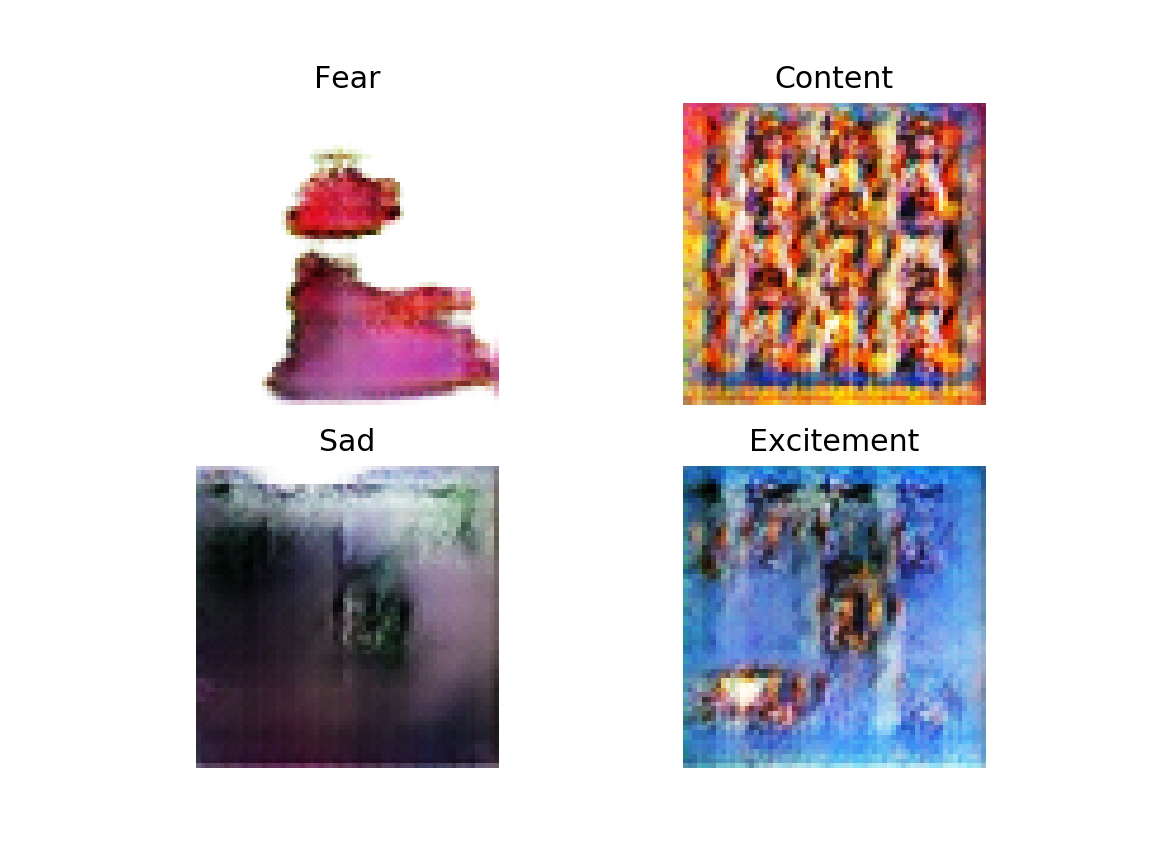

In [26]:
fig1, axes1 = plt.subplots(2, 2, sharex='all', sharey='all')

map_dict = {'Amusement': 0,'Anger': 1,'Awe': 2,'Content': 3,'Disgust': 4,'Excitement': 5,'Fear': 6,'Sad': 7}
rev = dict((v,k) for k,v in map_dict.items())

img_list = []
label_list = []

for i in range(len(pred_set)):
    with torch.no_grad():
        output = exp1.net(pred_set[i][np.newaxis].to(exp1.net.device))[0]
    values, indices = torch.max(output, 0)
    label = rev[int(indices)]
    img_list.append(pred_set[i])
    label_list.append(label)
    if i == 0 or i == 1:
        axes1[0][i].set_title(label)
        myimshow(pred_set[i], ax=axes1[0][i])
    binary = [int(x) for x in list('{0:0b}'.format(i))]
    if i > 1:
        axes1[binary[0]][binary[1]].set_title(label)
        myimshow(pred_set[i], ax=axes1[binary[0]][binary[1]])
        